In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
file_path = '/content/drive/My Drive/Colab Notebooks/cleaned_training_data.csv'

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
data = pd.read_csv(file_path,  header=0)

In [ ]:
# # Subsample the majority class
# data_majority = data[data['bad_flag'] == 0]
# data_minority = data[data['bad_flag'] == 1]

# # Downsample majority class
# data_majority_downsampled = data_majority.sample(2*len(data_minority), random_state=42)

# data_balanced = pd.concat([data_majority_downsampled, data_minority])

# # Shuffle the balanced dataset
# data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
data.columns


Index(['term', 'int_rate', 'emp_length', 'annual_inc', 'percent_bc_gt_75',
       'bc_util', 'dti', 'inq_last_6mths', 'mths_since_recent_inq',
       'total_bc_limit', 'tot_cur_bal', 'internal_score', 'bad_flag',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

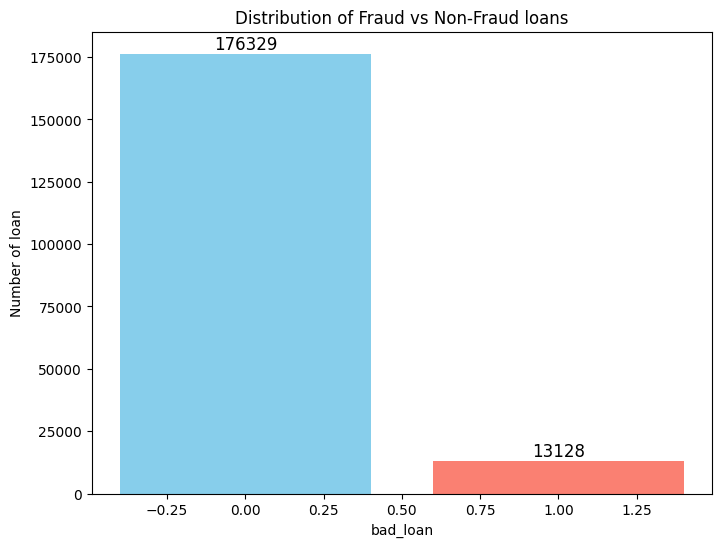

In [ ]:
fraud_counts = data['bad_flag'].value_counts()
plt.figure(figsize=(8, 6))
bars = plt.bar(fraud_counts.index, fraud_counts.values, color=['skyblue', 'salmon'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, str(yval), ha='center', va='bottom', fontsize=12)

plt.xlabel('bad_loan')
plt.ylabel('Number of loan')
plt.title('Distribution of Fraud vs Non-Fraud loans')

plt.show()    ## show distribution of fraud and non-fraud

In [6]:
y = data['bad_flag'].astype(float)
X = data.drop(columns=['bad_flag', 'bc_util'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.10, random_state=1000
)

In [36]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [37]:
X_t, X_val, y_t, y_val = train_test_split(
    X_train_smote, y_train_smote, stratify=y_train_smote, test_size=0.10, random_state=1000
)

In [38]:
numer = ['term', 'int_rate', 'emp_length', 'annual_inc', 'percent_bc_gt_75',
        'dti', 'inq_last_6mths', 'mths_since_recent_inq',
       'total_bc_limit', 'tot_cur_bal', 'internal_score']
dummy = X_train.columns.difference(numer)

In [39]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_t[numer])
X_val_num_scaled = scaler.transform(X_val[numer])

In [40]:
X_train_scaled1 = pd.DataFrame(X_train_num_scaled, columns=numer, index=X_t.index)
X_train_scaled = pd.concat([X_train_scaled1, X_t[dummy]], axis=1)

X_val_scaled1 = pd.DataFrame(X_val_num_scaled, columns=numer, index=X_val.index)
X_val_scaled = pd.concat([X_val_scaled1, X_val[dummy]], axis=1)

In [41]:
print(y_train_smote.value_counts())

bad_flag
0.0    158696
1.0     79348
Name: count, dtype: int64


In [42]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_t.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [43]:
print(X_val_tensor.size(), y_val_tensor.size())

torch.Size([23805, 28]) torch.Size([23805])


In [44]:
print(X_train_tensor.shape, y_train_tensor.shape)

torch.Size([214239, 28]) torch.Size([214239])


In [45]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3,  output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        # self.dropout1 = nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        # self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        # self.relu4 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        # x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        # x = self.relu4(x)
        # x = self.fc5(x)
        x = self.sigmoid(x)
        return x

# Model configuration
input_size = X_train_tensor.shape[1]
print(input_size)
hidden_size1 = 128  # Configurable
hidden_size2 = 512
hidden_size3 = 128
# hidden_size4 = 128
output_size = 1

# Instantiate the model
model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3,  output_size)

28


In [32]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        # Xavier (Glorot) initialization for weights
        nn.init.xavier_uniform_(m.weight)
        # Initialize biases to zero
        nn.init.zeros_(m.bias)

In [33]:
model.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=28, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [37]:
from sklearn.utils.class_weight import compute_class_weight


# Compute class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',  # Ensures weights are inversely proportional to class frequencies
#     classes=np.unique(y_train),  # Classes in your dataset
#     y=y_train  # The target variable
# )
class_weights = torch.tensor([1.0, 10.0], dtype=torch.float32)  # Adjust based on your data
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
# Convert to PyTorch tensor
# class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [46]:

# Training loop
epochs = 200  # Configurable
batch_size = 64
clip_value = 1.0
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
patience = 15
best_val_accuracy = 0
early_stop_counter = 0

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
best_threshold = 0.5
best_f1_score = 0.0

for epoch in range(epochs):
    # optimizer.step()
    #



    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     early_stop_counter = 0
    # else:
    #     early_stop_counter += 1

    # if early_stop_counter >= patience:
    #     print("Early stopping triggered!")
    #     break

    model.train()
    total_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        # Get mini-batch
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch).squeeze(dim = -1)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()
        # print("Model output shape:", outputs.shape)
        # print("Target shape:", y_batch.shape)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        train_outputs = model(X_train_tensor).squeeze()
        train_predictions = (train_outputs > 0.5).float()
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_f1 = f1_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_recall = recall_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_precision = precision_score(y_train_tensor.numpy(), train_predictions.numpy())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor)

        # Generate probabilities for validation
        val_probabilities = torch.sigmoid(val_outputs).numpy()

        # Search for the best threshold to maximize F1-score
        thresholds = np.arange(0.1, 0.9, 0.01)
        for threshold in thresholds:
            val_predictions = (val_probabilities > threshold).astype(int)
            current_f1 = f1_score(y_val_tensor.numpy(), val_predictions)

            if current_f1 > best_f1_score:
                best_f1_score = current_f1
                best_threshold = threshold

        # Apply the best threshold for current evaluation
        val_predictions = (val_probabilities > best_threshold).astype(int)
        val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions)
        val_f1 = f1_score(y_val_tensor.numpy(), val_predictions)
        val_recall = recall_score(y_val_tensor.numpy(), val_predictions)
        val_precision = precision_score(y_val_tensor.numpy(), val_predictions)

    # Log epoch results
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Loss: {total_loss / len(X_train_tensor):.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Train F1: {train_f1:.4f}, Train Recall: {train_recall:.4f}, Train Precision: {train_precision:.4f}, "
          f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"Val F1: {val_f1:.4f}, Val Recall: {val_recall:.4f}, Val Precision: {val_precision:.4f}, "
          f"Best Threshold: {best_threshold:.2f}")
# Save the model
# torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/neural_net_model.pth")

Epoch 1/200, Loss: 0.0045, Train Accuracy: 0.9016, Train F1: 0.8272, Train Recall: 0.7070, Train Precision: 0.9967, Val Loss: 0.2746, Val Accuracy: 0.9024, Val F1: 0.8323, Val Recall: 0.7268, Val Precision: 0.9737, Best Threshold: 0.59
Epoch 2/200, Loss: 0.0042, Train Accuracy: 0.8829, Train F1: 0.8148, Train Recall: 0.7727, Train Precision: 0.8618, Val Loss: 0.2998, Val Accuracy: 0.9017, Val F1: 0.8335, Val Recall: 0.7384, Val Precision: 0.9567, Best Threshold: 0.70
Epoch 3/200, Loss: 0.0040, Train Accuracy: 0.9074, Train F1: 0.8420, Train Recall: 0.7398, Train Precision: 0.9769, Val Loss: 0.2524, Val Accuracy: 0.9122, Val F1: 0.8485, Val Recall: 0.7376, Val Precision: 0.9986, Best Threshold: 0.69
